<a href="https://colab.research.google.com/github/emma-ba/Classification_Error_Toolkit/blob/master/V3_2_COMPAS_Clustering_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import os
import math
import scipy.stats as stats
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

import warnings
warnings.filterwarnings('ignore')

# LOAD (META) DATA

In [3]:
data_shaper = pd.read_csv('https://raw.githubusercontent.com/MDankloff/ClusterCompas/main/Compas_error_shap.csv')

In [4]:
data_shaper.info()
#data_shaper.iloc[3]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 51 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   age                                2495 non-null   float64
 1   decile_score                       2495 non-null   float64
 2   priors_count                       2495 non-null   float64
 3   sex_Female                         2495 non-null   float64
 4   race_African-American              2495 non-null   float64
 5   race_Asian                         2495 non-null   float64
 6   race_Caucasian                     2495 non-null   float64
 7   race_Hispanic                      2495 non-null   float64
 8   race_Native American               2495 non-null   float64
 9   race_Other                         2495 non-null   float64
 10  age_scaled                         2495 non-null   float64
 11  decile_score_scaled                2495 non-null   float

In [5]:
data_shaper.head()

,age,decile_score,priors_count,sex_Female,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,...,Shap_race_Asian_scaled,Shap_race_Caucasian_scaled,Shap_race_Hispanic_scaled,Shap_race_Native American_scaled,Shap_race_Other_scaled,errors_scaled,TP_scaled,TN_scaled,FN_scaled,FP_scaled
0,33.0,4.0,6.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.212022,-0.028428,0.297156,0.049157,0.329638,1.303607,-0.575723,-0.783884,2.014923,-0.457088
1,34.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.028091,0.751564,-1.452893,0.049157,-0.328178,-0.767102,1.736948,-0.783884,-0.496297,-0.457088
2,30.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.106145,0.325008,-0.065022,0.049157,0.032566,1.303607,-0.575723,-0.783884,2.014923,-0.457088
3,31.0,10.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.067103,0.123069,0.007584,0.049157,0.170190,-0.767102,-0.575723,1.275699,-0.496297,-0.457088
4,34.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.048034,0.499824,0.172228,0.049157,0.012654,-0.767102,-0.575723,1.275699,-0.496297,-0.457088


# UTILS (all)

## Sets of Features (aka data columns)

In [90]:
#Master Dataset
META_COL = ['clusters', 'new_clusters']
META_COL_VIZ = ['Error_Type']

ERROR_COL = ['errors', 'TP', 'TN', 'FN', 'FP']
BASIC_COL = ['age', 'decile_score', 'priors_count']
DUMMY_COL = ['sex_Female','race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
                      'race_Native American', 'race_Other']

ERROR_COL_scaled = ['errors_scaled'] #, 'TP_scaled', 'TN_scaled', 'FN_scaled', 'FP_scaled']
BASIC_COL_scaled = ['age_scaled', 'decile_score_scaled', 'priors_count_scaled']
DUMMY_COL_scaled = ['sex_Female_scaled', 'race_Native American_scaled','race_Other_scaled',
                'race_African-American_scaled', 'race_Asian_scaled', 'race_Caucasian_scaled', 'race_Hispanic_scaled']
DUMMY_COL_scaled_light = ['sex_Female_scaled', 'race_African-American_scaled', 'race_Caucasian_scaled']

#SHAP is created on BASIC_COL_scaled and DUMMY_COL_scaled
SHAP_BASIC = ['Shap_age', 'Shap_decile_score', 'Shap_priors_count']
SHAP_DUMMY = ['Shap_sex_Female','Shap_race_African-American', 'Shap_race_Asian', 'Shap_race_Caucasian',
                         'Shap_race_Hispanic', 'Shap_race_Native American', 'Shap_race_Other']

SHAP_BASIC_scaled = ['Shap_age_scaled', 'Shap_decile_score_scaled', 'Shap_priors_count_scaled']
SHAP_DUMMY_scaled = ['Shap_sex_Female_scaled','Shap_race_African-American_scaled',
                     'Shap_race_Asian_scaled', 'Shap_race_Caucasian_scaled','Shap_race_Hispanic_scaled',
                     'Shap_race_Native American_scaled', 'Shap_race_Other_scaled']
SHAP_DUMMY_scaled_light = ['Shap_sex_Female_scaled','Shap_race_African-American_scaled','Shap_race_Caucasian_scaled']

## DATA PREP UTILS

In [7]:
#Seperate TPFN & TNFP dataset
'''Drop rows where both TP and FN are 0 '''
def subset_TP_FN(data):
    return data.loc[(data['TP'] == 1) | (data['FN'] == 1)]

'''Drop rows where both TN and FP are 0'''
def subset_TN_FP(data):
    return data.loc[(data['TN'] == 1) | (data['FP'] == 1)]

In [8]:
'''undo Dummy for DUMMY_RACE or DUMMY_GENDER'''
def undo_dummy(data, with_Dummy, col_label, numeric_values=True, short_label=None):
  data[col_label] = ''
  for i, c in enumerate(with_Dummy):
    values = np.sort(data[c].unique())
    if numeric_values:
      data.loc[data[c] == values[1], col_label] = i
    else:
      if short_label is None:
        raise ValueError("short label must be provided if numeric_values is False")
        data.loc[data[c] == values[1], col_label] = short_label[i]
    data = data.drop(c, axis=1)
  return(data)

#data = undo_dummy(data, DUMMY_RACE, col_label='race', numeric_values=False, short_label=SHORT_LABEL_RACE)
#data = undo_dummy(data, DUMMY_GENDER, col_label='gender', numeric_values=False, short_label=SHORT_LABEL_GENDER)

In [9]:
def initialize_dataset(data):
    # Make deep copy of the dataset
    new_data = data.copy(deep=True)

    # Initialize clusters and new_clusters columns
    new_data['clusters'] = 0
    new_data['new_clusters'] = -1

    return new_data

## UTILS for BIAS in ERROR DIFFERENCE

In [10]:
# Calculate average Error rate based on unscaled error rate by counting the amount of max values (1) and dividing them by the total nr of rows - replacing old accuracy_error() from V1
# Does not work on scaled (binary) error features
def get_error_rate(data, column='errors'):
  if len(data) == 0:
    print ('calculating error rate on an empty set')
    return
  max_value = data[column].max()
  count_max_value = (data[column] == max_value).sum()
  average_error_rate = count_max_value / len(data)
  return average_error_rate

'''Calculate BIAS in terms of Error Difference
bias_type can be 'negative', 'positive' or 'absolute'
baseline can be 'all' which is the overall error rate, or 'other' or 'best' '''

def get_error_diff(data, cluster_id, cluster_col, bias_type = 'negative', baseline= 'all'):
  cluster_x= data.loc[data[cluster_col] == cluster_id]
  remaining_clusters = data.loc[data[cluster_col] != cluster_id]

  if len(cluster_x) == 0:
    print ('calculating error difference on an empty cluster')
    return

  if baseline == 'all':
    error_diff = get_error_rate(cluster_x) - get_error_rate(data)

  elif baseline == 'other':
    if len(remaining_clusters) == 0:
      print ("This cluster is the entire dataset. Cluster:", cluster_id)
      return
    error_diff = get_error_rate(cluster_x) - get_error_rate(remaining_clusters)

  elif baseline == 'best':
    best_cluster = get_min_bias_cluster(data, cluster_col, bias_type, baseline)
    error_diff = get_error_rate(cluster_x) - best_cluster[1]

  else:
    print ('unknown baseline')
    return

  #if full_info:
    #return [error_diff, function(cluster_x), function(remaining_clusters)]

  if bias_type == 'negative':
    pass #no change needed
  elif bias_type == 'positive':
    error_diff = -error_diff
  elif bias_type == 'absolute':
    error_diff = np.absolute(error_diff)
  else:
    print("unknown bias type")
    return

  return error_diff

## UTILS FOR CLUSTERING

In [59]:
def get_next_cluster(data, cluster_col, min_size, all_cluster_ids, banned_clusters):
  if(len(banned_clusters) != 0):
    mask = np.isin(all_cluster_ids, banned_clusters, invert=True)
    all_cluster_ids = all_cluster_ids[mask]

  for candidate_cluster_id in all_cluster_ids:
    if candidate_cluster_id == -1:
      continue

    #print ('This is the next cluster:', candidate_cluster_id)

    candidate_cluster = data.loc[data[cluster_col] == candidate_cluster_id]

    if len(candidate_cluster) < min_size:
      #print('...it is too small:', len(candidate_cluster))
      continue
    else:
      return(candidate_cluster_id)

  #print('No suitable clusters were found!')
  return(-1)

In [12]:
# [!!! OLD !!!]
#get cluster with max error difference
def get_max_bias_cluster(data, cluster_col= 'clusters', bias_type = 'negative', baseline = 'all', function = get_error_diff):
  max_bias = 0 #min possible bias
  max_bias_cluster = -2

  for cluster_id in data[cluster_col].unique():
    if cluster_id == -1: #outliers in dbscan
      continue

    current_bias = function(data, cluster_id, cluster_col, bias_type, baseline) #pos function to find highest bias

    if current_bias > max_bias:
      max_bias = current_bias
      max_bias_cluster = cluster_id

    return(max_bias_cluster, max_bias)

#get cluster with min error difference
def get_min_bias_cluster(data, cluster_col= 'clusters', bias_type = 'negative', baseline = 'all', function = get_error_diff):
  min_bias = 1 #max possible bias and look for smt smaller
  min_bias_cluster = -2

  for cluster_id in data[cluster_col].unique():
    if cluster_id == -1: #outliers in dbscan
      continue
    current_bias = function(data, cluster_id, cluster_col, bias_type, baseline)
    if current_bias < min_bias:
      min_bias = current_bias
      min_bias_cluster = cluster_id
  return(min_bias_cluster, min_bias)

#get size of the smallest cluster
def get_min_cluster_size(data, cluster_col = 'new_clusters'):
  min_cluster_size = len(data)
  for i in data['new_clusters'].unique():
    if i == -1: #exclude the -1 clusters as they may present outliers (in dbscan?)
      continue
      size = len(data.loc[data['new_clusters'] == i])
      if size < min_cluster_size: #update if new cluster size is smaller
        min_cluster_size = size
  return(min_cluster_size)

def select_new_cluster(data, cluster_col='clusters', error_column='errors', overall_error_rate=0.5, bias_type='negative', baseline='all'):
    smallest_diff = float('inf')
    selected_cluster = None

    for cluster_id in data[cluster_col].unique():
        if cluster_id == -1: #skip outlier
            continue

        error_diff = get_error_diff(data, cluster_id, cluster_col, bias_type, baseline) #calculate the error_diff for each cluster

        if error_diff is None:
            continue

        abs_diff = abs(overall_error_rate - (get_error_rate(data[data[cluster_col] == cluster_id]))) #get cluster with the smallest absolute difference with the overall error rate (0.5)

        if abs_diff < smallest_diff:
            smallest_diff = abs_diff
            selected_cluster = cluster_id
    return selected_cluster

def exit_clustering(data, msg='', bias_type='', iter=''):
  print('Iteration ', iter, ': ', msg)
  print('Overall error rate: ', get_error_rate(data))
  for c in np.sort(data['clusters'].unique()):
    print('Cluster: ', c, '\tSize: ', len(data.loc[data['clusters'] == c]), '\tError rate: ', get_error_rate(data.loc[data['clusters'] == c]))
  pca_plot(data,'HBAC-DBSCAN on COMPAS - ' + bias_type + ' bias', hue='clusters', s=15, alpha=0.8)
  return data


## UTILS for VIZ

### PCA

In [13]:
def pca_plot(data, title, perplexity, learning_rate, n_iter, alpha, pca_columns= [], other_columns=[], error='error'):

    if title is None:
        title = f'K-means for {error}\n'

    # Extract features for t-SNE and drop other_columns
    pca_features = data[pca_columns]
    other_columns = [col for col in data.columns if col not in pca_features]
    other_features = data[other_columns]

    tsne = TSNE(n_components=2, perplexity= 30, learning_rate= 200, n_iter= 1000)
    tsne_result = tsne.fit_transform(tsne_features)
    tsne_df = pd.DataFrame(tsne_result, index = tsne_features.index, columns=['t-SNE Component 1', 't-SNE Component 2'])

    # Apply PCA with 2 components to scaled features and create a df for the resulting principal components
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(pca_features)
    pca_df = pd.DataFrame(pca_result, index=pca_features.index, columns=['PC1', 'PC2'])

    # Create temporary dataset that contains both principal components and other features
    temp_dataset = pca_df.join(other_features, how='left')

    scatterplot = sns.scatterplot(data=temp_dataset, x='PC1', y='PC2', alpha=alpha, hue="Error_Type", palette='tab10', style='Error_Type')
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()

### TSNE

In [14]:
'''
PARAMS:
    - alpha: float, transparency level for plot points
    - tsne_columns: list of str, columns used for t-SNE
    - error: str type for title
    - perplexity: float, perplexity parameter for t-SNE
    - learning_rate: float,learning rate parameter for t-SNE
    - other_columns: list of str, other columns to include in the plot
'''

def tsne_plot(data, title, perplexity, learning_rate, n_iter, alpha, tsne_columns= [], other_columns=[], error='error'):

    if title is None:
        title = f'K-means for {error}\n'

    # Extract features for t-SNE and drop other_columns
    tsne_features = data[tsne_columns]
    other_columns = [col for col in data.columns if col not in tsne_features]
    other_features = data[other_columns]

    tsne = TSNE(n_components=2, perplexity= 30, learning_rate= 200, n_iter= 1000)
    tsne_result = tsne.fit_transform(tsne_features)
    tsne_df = pd.DataFrame(tsne_result, index = tsne_features.index, columns=['t-SNE Component 1', 't-SNE Component 2'])

    temp_dataset = tsne_df.join(other_features, how='left')

    # Create scatterplot using seaborn
    scatterplot = sns.scatterplot(data=temp_dataset, x='t-SNE Component 1', y='t-SNE Component 2', alpha=alpha, hue="Error_Type", palette='tab10', style='Error_Type')
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    plt.show()

# PREPARE DATA

In [15]:
# Split into TP/FN and TN/FP
TPFN_data = subset_TP_FN(data_shaper)
TNFP_data = subset_TN_FP(data_shaper)

In [16]:
# Drop NA's
TPFN_data = TPFN_data.dropna()
TNFP_data = TNFP_data.dropna()

In [17]:
# Scale features [Emma: redundant? but good to redo just in case]
scaler = StandardScaler()
features_to_scale = ERROR_COL_scaled + BASIC_COL_scaled + DUMMY_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled

TPFN_data[features_to_scale] = scaler.fit_transform(TPFN_data[features_to_scale])
TNFP_data[features_to_scale] = scaler.fit_transform(TNFP_data[features_to_scale])

#TPFN_data.iloc[3]

# VISUALIZE DATA


In [18]:
#pca_plot(TPFN_init, title=None, alpha = 0.5, pca_columns = BASIC_COL_scaled + DUMMY_COL_scaled + ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled, other_columns=None, error='error')
tsne_plot(TPFN_data, title='t-SNE for True Positives and False Negatives', alpha = 0.5, tsne_columns =BASIC_COL_scaled + DUMMY_COL_scaled + ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled, other_columns=None, error='error', perplexity=30, learning_rate =200, n_iter= 1000)

KeyboardInterrupt: 

In [ ]:
#pca_plot(TNFP_init, error = 'error', title=None, alpha = 0.5, pca_columns = BASIC_COL_scaled + DUMMY_COL_scaled + ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled, other_columns=None)
tsne_plot(TNFP_data, error= 'error', title='t-SNE for True Negatives and False Positives', alpha=0.5, tsne_columns = BASIC_COL_scaled + DUMMY_COL_scaled + ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled, other_columns=None, perplexity=30, learning_rate =200, n_iter= 1000)

# K-MEANS CLUSTERING

In [58]:
def hbac_kmeans(data, columns_to_use=[], error='errors',
                min_splittable_cluster_prop = 0.05,
                min_acceptable_cluster_prop = 0.03,
                max_iter=300):
    clus_model_kwargs = {
        "n_clusters": 2,  # Number of clusters to form
        "init": "k-means++",  # Centroids initialization method
        "n_init": 10,  # Number of initializations
        "max_iter": max_iter,  # Maximum iterations for a single run
    }

    min_splittable_cluster_size = round(min_splittable_cluster_prop * len(data))  # Minimum size of cluster to be split
    min_acceptable_cluster_size = round(min_acceptable_cluster_prop * len(data))  # Minimum acceptable size of cluster after split

    # Initialize loop's variables
    data['clusters'] = 0
    banned_clusters = []

    #### CLUSTERING LOOP
    for i in range(1, max_iter):
      # Init temporary cluster
      data['new_clusters'] = None

      ### Select the cluster to split in 2
      x = get_next_cluster(data, 'clusters', min_splittable_cluster_size, data['clusters'].unique(), banned_clusters)
      if(x == -1):
        break

      candidate_cluster = data.copy(deep=True)
      candidate_cluster = candidate_cluster.loc[candidate_cluster['clusters'] == x]

      #### SPLIT IN 2 SUB-CLUSTERS
      kmeans = KMeans(**clus_model_kwargs).fit(candidate_cluster[columns_to_use])
      candidate_cluster['new_clusters'] = kmeans.predict(candidate_cluster[columns_to_use])

      # KEEP CLUSTER OR NOT
      error_rate_c0 = get_error_rate(candidate_cluster.loc[candidate_cluster['new_clusters'] == 0])
      error_rate_c1 = get_error_rate(candidate_cluster.loc[candidate_cluster['new_clusters'] == 1])

      l0 = len(candidate_cluster.loc[candidate_cluster['new_clusters'] == 0])
      l1 = len(candidate_cluster.loc[candidate_cluster['new_clusters'] == 1])

      if((l0 < min_acceptable_cluster_size) | (l1 < min_acceptable_cluster_size)):
        #print('Bad Split')
        banned_clusters.append(x)
        continue

      ### Re-integrate to main data
      data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(data['new_clusters'])  # Combine new clusters with existing ones

      # Make new Cluster IDs
      new_id = data['clusters'].unique().max() + 1
      data.loc[((data.clusters == x) & (data.new_clusters == 1)), 'clusters'] = new_id

    #print('Max iterations reached:', i)
    return data

# RESULTS (BASIC)


In [85]:
def apply_hbac_kmeans(data,
                       columns_to_use = ERROR_COL_scaled + BASIC_COL_scaled + DUMMY_COL_scaled,
                       error='errors',
                       min_splittable_cluster_prop = 0.02,
                       min_acceptable_cluster_prop = 0.02,
                       max_iter=100):

  res_all = hbac_kmeans(data=data,
                       columns_to_use = columns_to_use,
                       error=error,
                       min_splittable_cluster_prop = min_splittable_cluster_prop,
                       min_acceptable_cluster_prop = min_acceptable_cluster_prop,
                       max_iter=max_iter)

  # Prepare recap of cluster info
  # ...with error rates
  res = res_all[['clusters', 'errors']]

  # ...with cluster size
  temp = res_all[['clusters']]
  temp['count'] = 1
  recap = temp.groupby(['clusters'], as_index=False).sum()

  # ...with number of error
  recap['n_error'] = res.groupby(['clusters']).sum().astype(int)

  # ...with 1-vs-All error diff
  recap['error_rate'] = res.groupby(['clusters']).mean()
  recap['std'] = (recap['error_rate'] * (1-recap['error_rate']))/recap['count']
  recap['std'] = recap['std'].apply(np.sqrt)

  # ... with error differences (1 vs Rest)
  diff_vs_rest = []
  diff_std = []
  diff_p =[]

  for c in recap['clusters']:
    rest_data = recap.loc[recap['clusters'] != c]
    rest_n_error = rest_data['n_error'].sum()
    rest_count = rest_data['count'].sum()
    rest_rate = rest_n_error / rest_count
    diff = recap['error_rate'][c] - rest_rate
    diff_vs_rest.append(diff)

    # ...with std deviation of error differences
    std_rest = (rest_rate * (1-rest_rate))/rest_data['count'].sum()
    std_rest = np.sqrt(std_rest)
    diff_std.append(recap['std'][c] + std_rest)

    # ...with Poisson stat test
    res = stats.poisson_means_test(recap['n_error'][c], recap['count'][c], rest_n_error, rest_count)
    diff_p.append(round(res.pvalue, 3))

  recap['diff_vs_rest'] = diff_vs_rest
  recap['diff_std'] = diff_std
  recap['diff_p'] = diff_p

  recap.rename(columns={'clusters':'c'}, inplace=True)
  print(recap.sort_values(by=['diff_p']))

  return(res_all, recap)

In [86]:
res_baseline = apply_hbac_kmeans(TNFP_data,
                  columns_to_use = BASIC_COL_scaled + DUMMY_COL_scaled_light,
                  error='errors',
                  min_splittable_cluster_prop = 0.04,
                  min_acceptable_cluster_prop = 0.03,
                  max_iter=100)

     c  count  n_error  error_rate       std  diff_vs_all  diff_std  diff_p
0    0    129      109    0.844961  0.031867     0.588854  0.044120   0.000
6    6     82        9    0.109756  0.034519    -0.213192  0.047409   0.000
9    9     84        9    0.107143  0.033747    -0.216297  0.046652   0.000
12  12     58        5    0.086207  0.036854    -0.233942  0.049598   0.000
14  14     51        2    0.039216  0.027181    -0.281497  0.039898   0.000
4    4     73        9    0.123288  0.038479    -0.197467  0.051302   0.001
8    8    166       80    0.481928  0.038782     0.194590  0.051675   0.001
10  10    105       17    0.161905  0.035949    -0.160601  0.048948   0.001
11  11     84       14    0.166667  0.040663    -0.152968  0.053527   0.004
1    1    102       22    0.215686  0.040725    -0.102215  0.053660   0.041
13  13     55       24    0.436364  0.066872     0.131077  0.079438   0.155
7    7    205       73    0.356098  0.033444     0.053499  0.046744   0.232
2    2     7

In [91]:
res_baseline_wError = apply_hbac_kmeans(TNFP_data,
                  columns_to_use = ERROR_COL_scaled + BASIC_COL_scaled + DUMMY_COL_scaled_light,
                  error='errors',
                  min_splittable_cluster_prop = 0.04,
                  min_acceptable_cluster_prop = 0.03,
                  max_iter=100)

     c  count  n_error  error_rate       std  diff_vs_all  diff_std  diff_p
0    0    126      106    0.841270  0.032555     0.583408  0.044820   0.000
12  12     65        8    0.123077  0.040749    -0.196503  0.053521   0.001
7    7     96       16    0.166667  0.038036    -0.154378  0.050975   0.002
8    8     73       11    0.150685  0.041870    -0.168560  0.054678   0.003
15  15     54        7    0.129630  0.045710    -0.188079  0.058409   0.004
6    6     57        8    0.140351  0.046008    -0.177323  0.058721   0.005
10  10     62       37    0.596774  0.062299     0.299619  0.074802   0.009
11  11     50        8    0.160000  0.051846    -0.156024  0.064509   0.019
16  16     51        9    0.176471  0.053381    -0.139045  0.066044   0.035
17  17     55       10    0.181818  0.052007    -0.133893  0.064690   0.037
3    3     54       10    0.185185  0.052861    -0.130291  0.065537   0.044
4    4     91       20    0.219780  0.043409    -0.096976  0.056277   0.067
14  14    10

In [88]:
res_w_SHAP = apply_hbac_kmeans(TNFP_data,
                  columns_to_use = BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light,
                  error='errors',
                  min_splittable_cluster_prop = 0.04,
                  min_acceptable_cluster_prop = 0.03,
                  max_iter=100)

     c  count  n_error  error_rate       std  diff_vs_all  diff_std  diff_p
1    1     69       60    0.869565  0.040544     0.588151  0.052879   0.000
2    2    113       15    0.132743  0.031918    -0.193327  0.044995   0.000
9    9     65        5    0.076923  0.033051    -0.244907  0.045847   0.000
0    0    115       66    0.573913  0.046113     0.287085  0.058740   0.001
3    3     81       17    0.209877  0.045247    -0.106752  0.058064   0.053
7    7     57       11    0.192982  0.052271    -0.122454  0.064961   0.054
8    8     55       11    0.200000  0.053936    -0.114966  0.066611   0.076
17  17     65       14    0.215385  0.050989    -0.099694  0.063713   0.103
10  10     56       12    0.214286  0.054832    -0.100170  0.067506   0.126
15  15     42        9    0.214286  0.063315    -0.099136  0.075912   0.185
11  11     60       14    0.233333  0.054603    -0.080568  0.067290   0.216
16  16     56       22    0.392857  0.065263     0.085853  0.077854   0.317
13  13     5

In [92]:
res_w_SHAP_wError = apply_hbac_kmeans(TNFP_data,
                  columns_to_use = ERROR_COL_scaled + BASIC_COL_scaled + DUMMY_COL_scaled_light + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light,
                  error='errors',
                  min_splittable_cluster_prop = 0.04,
                  min_acceptable_cluster_prop = 0.03,
                  max_iter=100)

     c  count  n_error  error_rate       std  diff_vs_all  diff_std  diff_p
0    0     70       61    0.871429  0.040007     0.590555  0.052340   0.000
1    1    110       64    0.581818  0.047031     0.294551  0.059639   0.001
7    7    133       23    0.172932  0.032793    -0.151969  0.045961   0.001
15  15     68        9    0.132353  0.041095    -0.187196  0.053881   0.001
2    2     58       10    0.172414  0.049600    -0.144004  0.062305   0.021
14  14     56       10    0.178571  0.051180    -0.137375  0.063870   0.031
5    5     84       18    0.214286  0.044770    -0.102305  0.057602   0.060
4    4     83       18    0.216867  0.045235    -0.099482  0.058060   0.070
6    6     54       11    0.203704  0.054807    -0.111028  0.067475   0.091
9    9     64       14    0.218750  0.051675    -0.096093  0.064391   0.120
3    3    100       35    0.350000  0.047697     0.042604  0.060504   0.487
11  11     48       13    0.270833  0.064142    -0.041019  0.076750   0.596
8    8     8

In [93]:
res_SHAPonly = apply_hbac_kmeans(TNFP_data,
                  columns_to_use = SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light,
                  error='errors',
                  min_splittable_cluster_prop = 0.04,
                  min_acceptable_cluster_prop = 0.03,
                  max_iter=100)

     c  count  n_error  error_rate       std  diff_vs_all  diff_std  diff_p
11  11     54       24    0.444444  0.067620     0.139385  0.080179   0.139
7    7    113       28    0.247788  0.040614    -0.068166  0.053582   0.171
17  17     50       11    0.220000  0.058583    -0.093798  0.071222   0.177
2    2     80       20    0.250000  0.048412    -0.064112  0.061198   0.273
1    1     91       34    0.373626  0.050712     0.067582  0.063460   0.309
16  16     60       15    0.250000  0.055902    -0.063154  0.068581   0.346
4    4     76       28    0.368421  0.055332     0.061311  0.068020   0.392
18  18     42       16    0.380952  0.074933     0.072693  0.087473   0.455
13  13    122       34    0.278689  0.040592    -0.034791  0.053579   0.491
3    3     58       21    0.362069  0.063106     0.053860  0.075720   0.506
8    8     88       25    0.284091  0.048075    -0.028123  0.060878   0.635
14  14     70       24    0.342857  0.056733     0.034122  0.069410   0.636
12  12     5

In [94]:
res_SHAPonly_wError = apply_hbac_kmeans(TNFP_data,
                  columns_to_use = ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled_light,
                  error='errors',
                  min_splittable_cluster_prop = 0.04,
                  min_acceptable_cluster_prop = 0.03,
                  max_iter=100)

     c  count  n_error  error_rate       std  diff_vs_all  diff_std  diff_p
3    3     44        7    0.159091  0.055141    -0.156271  0.067768   0.026
17  17     63       25    0.396825  0.061638     0.090458  0.074255   0.268
6    6     58       14    0.241379  0.056189    -0.072054  0.068861   0.282
13  13     50       13    0.260000  0.062032    -0.052315  0.074655   0.481
15  15     86       30    0.348837  0.051393     0.040910  0.064138   0.535
12  12     73       20    0.273973  0.052200    -0.038480  0.064933   0.546
2    2     60       21    0.350000  0.061577     0.041330  0.074205   0.598
10  10     55       19    0.345455  0.064119     0.036445  0.076728   0.655
9    9     59       20    0.338983  0.061627     0.029797  0.074257   0.703
8    8    107       35    0.327103  0.045355     0.018040  0.058216   0.754
5    5     45       13    0.288889  0.067566    -0.022271  0.080152   0.786
1    1    273       83    0.304029  0.027840    -0.007971  0.041653   0.832
7    7     7

In [96]:
res_SENSonly_wError = apply_hbac_kmeans(TNFP_data,
                  columns_to_use = ERROR_COL_scaled + DUMMY_COL_scaled_light,
                  error='errors',
                  min_splittable_cluster_prop = 0.04,
                  min_acceptable_cluster_prop = 0.03,
                  max_iter=100)

calculating error rate on an empty set
calculating error rate on an empty set
calculating error rate on an empty set
calculating error rate on an empty set
calculating error rate on an empty set
calculating error rate on an empty set
   c  count  n_error  error_rate       std  diff_vs_all  diff_std  diff_p
4  4    314      129    0.410828  0.027764     0.129463  0.041422   0.001
3  3    182       81    0.445055  0.036838     0.154759  0.049854   0.004
2  2     69       12    0.173913  0.045630    -0.143619  0.058400   0.014
7  7    139       32    0.230216  0.035706    -0.089085  0.048845   0.045
0  0    118       27    0.228814  0.038670    -0.089155  0.051687   0.061
1  1    253       67    0.264822  0.027740    -0.055702  0.041532   0.128
5  5    126       32    0.253968  0.038778    -0.062069  0.051814   0.195
6  6    122       33    0.270492  0.040217    -0.043772  0.053213   0.379
8  8     75       21    0.280000  0.051846    -0.032169  0.064586   0.612


In [97]:
res_SENSonly_wSHAP_wError = apply_hbac_kmeans(TNFP_data,
                  columns_to_use = ERROR_COL_scaled + DUMMY_COL_scaled_light + SHAP_DUMMY_scaled_light,
                  error='errors',
                  min_splittable_cluster_prop = 0.04,
                  min_acceptable_cluster_prop = 0.03,
                  max_iter=100)

     c  count  n_error  error_rate       std  diff_vs_all  diff_std  diff_p
11  11    134       61    0.455224  0.043020     0.160129  0.055848   0.011
6    6    106       22    0.207547  0.039391    -0.111338  0.052356   0.023
12  12    142       32    0.225352  0.035062    -0.094712  0.048225   0.031
9    9     69       16    0.231884  0.050807    -0.082638  0.063544   0.173
3    3     59       25    0.423729  0.064333     0.118277  0.076920   0.177
4    4    113       43    0.380531  0.045674     0.076251  0.058509   0.207
2    2     64       15    0.234375  0.052951    -0.079718  0.065659   0.208
13  13     79       31    0.392405  0.054936     0.086871  0.067620   0.232
7    7     68       17    0.250000  0.052511    -0.063534  0.065232   0.315
8    8     42       10    0.238095  0.065721    -0.074589  0.078310   0.338
1    1    193       66    0.341969  0.034146     0.036575  0.047414   0.417
10  10     86       23    0.267442  0.047729    -0.045820  0.060535   0.430
5    5    13

In [95]:
res_SENSonly_SHAPonly_wError = apply_hbac_kmeans(TNFP_data,
                  columns_to_use = ERROR_COL_scaled + SHAP_DUMMY_scaled_light,
                  error='errors',
                  min_splittable_cluster_prop = 0.04,
                  min_acceptable_cluster_prop = 0.03,
                  max_iter=100)

     c  count  n_error  error_rate       std  diff_vs_all  diff_std  diff_p
7    7     74       15    0.202703  0.046733    -0.113763  0.059515   0.046
11  11     72       17    0.236111  0.050050    -0.078369  0.062801   0.192
8    8    116       44    0.379310  0.045051     0.075098  0.057901   0.208
12  12     93       23    0.247312  0.044739    -0.067631  0.057597   0.213
0    0    142       50    0.352113  0.040082     0.046380  0.053082   0.375
1    1     67       25    0.373134  0.059086     0.065847  0.071732   0.391
5    5    107       37    0.345794  0.045981     0.038281  0.058824   0.517
10  10     45       16    0.355556  0.071358     0.046612  0.083919   0.609
3    3    125       36    0.288000  0.040502    -0.024647  0.053495   0.627
4    4     97       28    0.288660  0.046009    -0.023408  0.058855   0.680
6    6     62       21    0.338710  0.060105     0.029578  0.072749   0.696
9    9     62       18    0.290323  0.057647    -0.021055  0.070315   0.765
13  13     4

# RQ'S


**RQ1: is there a relationshop between shap & risk of error?**

TPFN_init & TNFP_init = *all columns*

SE = shap and error columns

FE = all columns except shap (selma)


--------------------------------------------------
**RQ2: does shap help in finding disc clusters?**

FS = all columns except error

S = only SHAP_COL

F = only BASIC_COL


# SHAP & ERROR & BASIC COL

***Clustering all columns TP FN DATA***

In [ ]:
clustered_shap_err_basic_TPFN = hbac_kmeans(data=TPFN_init, columns_to_use=BASIC_COL_scaled + DUMMY_COL_scaled + ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled, error='errors', max_iter=1000, show_plot=True)
plt.show()

Error rate: 0.4421148587055606
Discriminative bias: -0.005794103988579491
Smallest cluster size: 1097
Max iterations reached
[0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.442114858705

In [ ]:
c= get_max_bias_cluster(clustered_shap_err_basic_TPFN)

Mean_error_rate_TPFN = get_error_rate(clustered_shap_err_basic_TPFN)

print ('Mean error rate of full TPFN data set:', Mean_error_rate_TPFN)

print (f" cluster {c} has the highest discrimination bias for TPFN data")


Mean error rate of full TPFN data set: 0.4421148587055606
 cluster (-2, 0) has the highest discrimination bias for TPFN data


***TPFN ALL COLUMNS ANOVA***

In [ ]:
'''SHAP, ERROR & BASIC COLUMNS FOR TPFN ANOVA'''
#check per identified cluster whether the errors significantly differ
groupstpfn = clustered_shap_err_basic_TPFN.groupby('clusters')['errors'].apply(list)
anovatpfn = [np.array(groupstpfn) for groupstpfn in groupstpfn]

f_stat, p_val = f_oneway(*anovatpfn)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

F-statistic: 0.09390631957908324
p-value: 0.7593268629080284
there are no statistically significant differences between the clusters


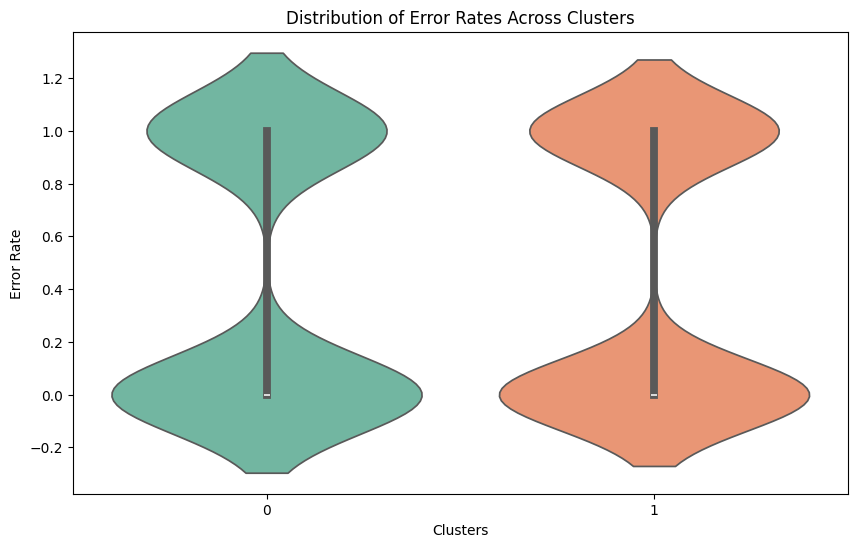

In [ ]:
# Prepare the data by melting the dataframe
melted_data = clustered_shap_err_basic_TPFN.melt(id_vars=['clusters'], value_vars=['errors'], var_name='Metric', value_name='Error Rate')

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='clusters', y='Error Rate', data=melted_data, inner='box', scale='width', palette='Set2')
plt.title('Distribution of Error Rates Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Error Rate')
plt.show()

***Clustering all columns TN FP DATA***

In [ ]:
clustered_shap_err_basic_TNFP = hbac_kmeans(data=TNFP_init, columns_to_use=BASIC_COL_scaled + DUMMY_COL_scaled + ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled, error='errors', max_iter=300, show_plot=True)
plt.show()

Error rate: 0.3104434907010014
Discriminative bias: -0.004119380029064645
Smallest cluster size: 1398
Max iterations reached
[0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.310443490701

In [ ]:
c= get_max_bias_cluster(clustered_shap_err_basic_TNFP)

Mean_error_rate_TNFP = get_error_rate(clustered_shap_err_basic_TNFP)

print ('Mean error rate of full TNFP data set:', Mean_error_rate_TNFP)

print (f" cluster {c} has the highest discrimination bias for TNFP data")


Mean error rate of full TNFP data set: 0.3104434907010014
 cluster (-2, 0) has the highest discrimination bias for TNFP data


***TNFP ALL COLUMNS ANOVA***

In [ ]:
'''SHAP, ERROR & BASIC COLUMNS FOR TNFP ANOVA'''
groupstnfp = clustered_shap_err_basic_TNFP.groupby('clusters')['FP'].apply(list)
anovatnfp = [np.array(groupstnfp) for groupstnfp in groupstnfp]

f_stat, p_val = f_oneway(*anovatnfp)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

F-statistic: 0.0627771951871686
p-value: 0.8021959917743023
there are no statistically significant differences between the clusters


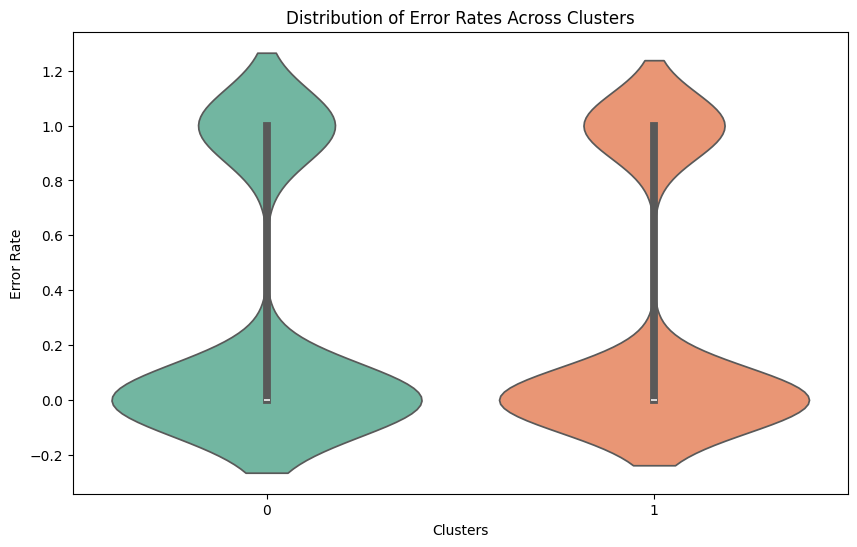

In [ ]:
# Prepare the data by melting the dataframe
melted_data = clustered_shap_err_basic_TNFP.melt(id_vars=['clusters'], value_vars=['errors'], var_name='Metric', value_name='Error Rate')

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='clusters', y='Error Rate', data=melted_data, inner='box', scale='width', palette='Set2')
plt.title('Distribution of Error Rates Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Error Rate')
plt.show()

# SHAP & ERROR COLUMNS NO BASIC FEATURES

In [ ]:
'''SE: SHAP_COL and ERROR_COL no BASIC_COL '''
columns = ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled + META_COL + META_COL_VIZ
SE_TPFN = TPFN_init[columns]
SE_TNFP = TNFP_init[columns] #scaled

#SE_TPFN.iloc[3]
SE_TNFP.iloc[3]

errors_scaled                        1.327722
TP_scaled                           -0.573496
TN_scaled                           -0.800528
FN_scaled                           -0.492612
FP_scaled                            2.236068
Shap_age_scaled                     -0.279174
Shap_decile_score_scaled            -0.800271
Shap_priors_count_scaled            -0.531185
Shap_sex_Female_scaled               0.273211
Shap_race_African-American_scaled    0.543617
Shap_race_Asian_scaled              -0.054634
Shap_race_Caucasian_scaled           1.949653
Shap_race_Hispanic_scaled            0.065513
Shap_race_Native American_scaled     0.042717
Shap_race_Other_scaled               0.178203
clusters                                    0
new_clusters                                0
Error_Type                                 TN
Name: 5, dtype: object

***SHAP AND ERROR KMEANS ON TPFN***

In [ ]:
'''KMEANS SHAP & ERROR COLUMNS FOR TPFN '''
Clustered_shap_err_TPFN = hbac_kmeans(data=TPFN_init, columns_to_use=ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled, error='errors', max_iter=300, show_plot=True)
plt.show()

Error rate: 0.4421148587055606
Discriminative bias: -0.005794103988579491
Smallest cluster size: 1097
Max iterations reached
[0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.442114858705

In [ ]:
c= get_max_bias_cluster(Clustered_shap_err_TPFN)

Mean_error_rate_SE_TPFN = get_error_rate(Clustered_shap_err_TPFN, 'errors')

print ('Mean error rate of SE_TPFN data set:', Mean_error_rate_SE_TPFN)

print (f" cluster {c} has the highest discrimination bias for TPFN data")

Mean error rate of SE_TPFN data set: 0.4421148587055606
 cluster (-2, 0) has the highest discrimination bias for TPFN data


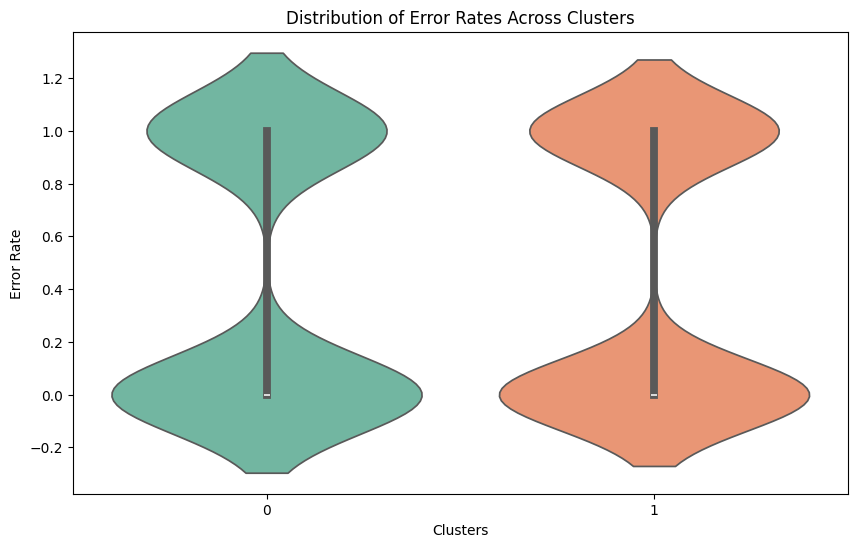

In [ ]:
melted_data = Clustered_shap_err_TPFN.melt(id_vars=['clusters'], value_vars=['errors'], var_name='Metric', value_name='Error Rate')

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='clusters', y='Error Rate', data=melted_data, inner='box', scale='width', palette='Set2')
plt.title('Distribution of Error Rates Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Error Rate')
plt.show()

***SHAP AND ERROR ANOVA ON TPFN***

In [ ]:
'''SHAP & ERROR COLUMNS FOR TPFN ANOVA'''
groupsSE_tpfn = Clustered_shap_err_TPFN.groupby('clusters')['errors'].apply(list)
anovaSE_tpfn = [np.array(groupsSE_tpfn) for groupsSE_tpfn in groupsSE_tpfn]

f_stat, p_val = f_oneway(*anovaSE_tpfn)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

F-statistic: 0.09390631957908324
p-value: 0.7593268629080284
there are no statistically significant differences between the clusters


***SHAP AND ERROR KMEANS ON TNFP***

In [ ]:
'''KMEANS SHAP & ERROR COLUMNS FOR TNFP'''
Clustered_shap_err_TNFP = hbac_kmeans(data = TNFP_init, columns_to_use=ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled, error='errors', max_iter=300, show_plot=True)
plt.show()

Error rate: 0.3104434907010014
Discriminative bias: -0.004119380029064645
Smallest cluster size: 1398
Max iterations reached
[0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.310443490701

In [ ]:
c= get_max_bias_cluster(Clustered_shap_err_TNFP)

Mean_error_rate_SE_TNFP = get_error_rate(Clustered_shap_err_TNFP, 'errors')

print ('Mean error rate of SE_TPFN data set:', Mean_error_rate_SE_TNFP)

print (f" cluster {c} has the highest discrimination bias for TPFN data")

Mean error rate of SE_TPFN data set: 0.3104434907010014
 cluster (-2, 0) has the highest discrimination bias for TPFN data


***SHAP AND ERROR ANOVA ON TNFP***

In [ ]:
'''SHAP & ERROR COLUMNS FOR TNFP ANOVA'''
groupsSE_tnfp = Clustered_shap_err_TNFP.groupby('clusters')['errors'].apply(list)
anovaSE_tnfp = [np.array(groupsSE_tpfn) for groupsSE_tnfp in groupsSE_tnfp]

f_stat, p_val = f_oneway(*anovaSE_tpfn)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

F-statistic: 0.09390631957908324
p-value: 0.7593268629080284
there are no statistically significant differences between the clusters


In [ ]:
Clustered_shap_err_TNFP.iloc[3]

age                                      40.0
decile_score                              1.0
priors_count                              0.0
sex_Female                                0.0
race_African-American                     1.0
race_Asian                                0.0
race_Caucasian                            0.0
race_Hispanic                             0.0
race_Native American                      0.0
race_Other                                0.0
age_scaled                           0.224279
decile_score_scaled                 -0.994168
priors_count_scaled                 -0.640735
sex_Female_scaled                   -0.532679
race_African-American_scaled         1.085159
race_Asian_scaled                   -0.053567
race_Caucasian_scaled               -0.762527
race_Hispanic_scaled                 -0.34018
race_Native American_scaled         -0.065653
race_Other_scaled                   -0.257607
errors                                    0.0
TP                                

# ERROR AND BASIC COLUMNS NO SHAP (SELMA)

In [ ]:
TPFN_init.iloc[3]

In [ ]:
'''FE: FEATURES AND ERROR NO SHAP (Selma) '''
columns_to_drop = SHAP_COL_Basic_scaled + SHAP_COL_Dummy_scaled

FE_TPFN = TPFN_init.drop(columns_to_drop, axis=1) #scaled
FE_TNFP = TNFP_init.drop(columns_to_drop, axis=1) #scaled

FE_TPFN.iloc[3]
#FE_TNFP.iloc[3]

***BASIC & ERROR K-MEANS ON TPFN***

In [ ]:
'''BASIC & ERROR K-MEANS ON TPFN'''
TPFN_init = initialize_dataset(TPFN_unscaled, unscaled=True, meta_col=True, with_error_col=True, with_classes=True)
hbac_kmeans(data = TPFN_init, columns_to_drop = ['SHAP_COL_Basic_scaled', 'SHAP_COL_Dummy_scaled'], error= 'FN', max_iter = 300, show_plot= True)
plt.show()

In [ ]:
c= get_max_bias_cluster(FE_TPFN)

Mean_error_rate_FE_TPFN = get_error_rate(FE_TPFN)

print ('Mean error rate of FE_TPFN data set:', Mean_error_rate_TPFN)

print (f" cluster {c} has the highest discrimination bias for FE_TPFN data")

In [ ]:
FE_TPFN.iloc[3]

***BASIC & ERROR ANOVA ON TPFN***

In [ ]:
'''BASIC & ERROR COLUMNS FOR TPFN ANOVA'''
groupsFE_tpfn = FE_TPFN.groupby('clusters')['FN'].apply(list)
anovaFE_tpfn = [np.array(groupsFE_tpfn) for groupsFE_tpfn in groupsFE_tpfn]

f_stat, p_val = f_oneway(*anovaFE_tpfn)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

***BASIC & ERROR K-MEANS ON TNFP***

In [ ]:
'''BASIC & ERROR COLUMNS FOR TNFP'''
TNFP_init = initialize_dataset(TNFP_unscaled, unscaled=True, meta_col=True, with_error_col=True, with_classes=True)
hbac_kmeans(data = TNFP_init, columns_to_drop= ['SHAP_COL_Basic_scaled', 'SHAP_COL_Dummy_scaled'], error= 'FP', max_iter = 300, show_plot= True)
plt.show()

In [ ]:
c= get_max_bias_cluster(FE_TNFP)

Mean_error_rate_FE_TNFP = get_error_rate(FE_TNFP)

print ('Mean error rate of FE_TNFP data set:', Mean_error_rate_TNFP)

print (f" cluster {c} has the highest discrimination bias for FE_TNFP data")

***BASIC & ERROR ANOVA ON TNFP***

In [ ]:
'''BASIC & ERROR COLUMNS FOR TNFP ANOVA'''
groupsFE_tnfp = FE_TNFP.groupby('clusters')['FP'].apply(list)
anovaFE_tnfp = [np.array(groupsFE_tnfp) for groupsFE_tnfp in groupsFE_tnfp]

f_stat, p_val = f_oneway(*anovaFE_tnfp)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

# SHAP & BASIC COLUMNS NO ERROR

In [ ]:
#TPFN_init.iloc[3]

In [ ]:
'''FS: FEATURES AND SHAP NO ERROR '''
columns_to_drop = ERROR_COL

FS_TPFN = TPFN_init.drop(columns_to_drop, axis=1) #scaled
FS_TNFP = TNFP_init.drop(columns_to_drop, axis=1) #scaled

FS_TPFN = initialize_dataset(FS_TPFN, unscaled=True, meta_col=True, with_error_col= False, with_classes=True)
FS_TNFP = initialize_dataset(FS_TNFP, unscaled=True, meta_col=True, with_error_col= False, with_classes=True)

FS_TPFN.iloc[3]
#FE_TNFP.iloc[3]

***BASIC & SHAP KMEANS ON TPFN***

In [ ]:
#Run it on TPFN_init and drop columns ERROR as you go through loop in clustering otherwise it doesn't work
TPFN_init = initialize_dataset(TPFN_unscaled, unscaled=True, meta_col=True, with_error_col=False, with_classes=True)
hbac_kmeans(data=TPFN_init, columns_to_drop= ['ERROR_COL'], error='FN', max_iter=300, show_plot=True)

***BASIC & SHAP ANOVA ON TPFN***

In [ ]:
#kept error_type in otherwise anova doesnt work
groupsFS_tpfn = FS_TPFN.groupby('clusters')['Error_Type'].apply(list)
anovaFS_tpfn = [np.array(groupsFS_tpfn) for groupsFS_tpfn in groupsSE_tpfn]

f_stat, p_val = f_oneway(*anovaFS_tpfn)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

***BASIC & SHAP KMEANS ON TNFP***

In [ ]:
TNFP_init = initialize_dataset(TNFP_unscaled, unscaled=True, meta_col=True, with_error_col=False, with_classes=True)
hbac_kmeans(data=TNFP_init, columns_to_drop=['ERROR_COL', 'META_COL'], error='FP', max_iter=300, show_plot=True)

***BASIC & SHAP ANOVA ON TNFP***

In [ ]:
#kept error_type in otherwise anova doesnt work
groupsFS_tnfp = FS_TNFP.groupby('clusters')['FP'].apply(list)
anovaFS_tnfp = [np.array(groupsFS_tnfp) for groupsFS_tnfp in groupsSE_tnfp]

f_stat, p_val = f_oneway(*anovaFS_tnfp)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

# ONLY SHAP COL

In [ ]:
columns_to_drop = BASIC_COL_unscaled + DUMMY_unscaled + ERROR_COL
S_TPFN = TPFN_init.drop(columns_to_drop, axis=1) #scaled
S_TNFP = TNFP_init.drop(columns_to_drop, axis=1)

S_TPFN.iloc[23]

***SHAP KMEANS ON TPFN***

In [ ]:
TPFN_init_S = initialize_dataset(TPFN_unscaled, unscaled=True, meta_col=True, with_error_col=False, with_classes=True)
#pass original dataset and not SE_TPFN otherwise the clustering doesn't work
hbac_kmeans(data = TPFN_init_S, columns_to_drop = ['BASIC_COL_unscaled', 'DUMMY_unscaled', 'ERROR_COL'], error= 'FN', max_iter = 300, show_plot= True)
plt.show()

In [ ]:
MAXnegbias = get_max_bias_cluster(TPFN_init_S, bias_type='negative', baseline='all')
#highest_biased_cluster = TPFN_init_S[TPFN_init_S['clusters'] == c]

print ('cluster ID with the max negative bias is (1st score) against a minimum possible bias of (2nd score)', (max_neg_bias))

MINnegbias = get_min_bias_cluster(TPFN_init_S, bias_type = 'negative', baseline = 'all')
print ('cluster ID with the min negative bias is (1st score) against a maximum possible  ', (min_neg_bias))

MAXposbias = get_max_bias_cluster(TPFN_init_S, bias_type='positive', baseline='all')
print ('cluster ID with the max positive bias is (1st score) against a minimum possible bias of (2nd score)', (max_pos_bias))

MINposbias = get_min_bias_cluster(TPFN_init_S, bias_type = 'positive', baseline = 'all')
print ('cluster ID with the min positive bias is (1st score) against a maximum possible  ', (min_pos_bias))



***SHAP ANOVA ON TPFN***

In [ ]:
#kept error_type in otherwise anova doesnt work
groupsS_tpfn = TPFN_init_S.groupby('clusters')['FN'].apply(list)

# Check the number of groups
print("Number of groups:", len(groupsS_tpfn))

anovaS_tpfn = [np.array(groupsS_tpfn) for groupsS_tpfn in groupsS_tpfn]

# Proceed with ANOVA only if there are at least two groups
if len(anovaS_tpfn) >= 2:
    f_stat, p_val = f_oneway(*anovaS_tpfn)

    print('F-statistic:', f_stat)
    print('p-value:', p_val)

    alpha = 0.05
    if p_val < alpha:
        print("there are statistically significant differences between the clusters.")
    else:
        print("there are no statistically significant differences between the clusters")
else:
    print("ANOVA cannot be performed with less than two groups.")

***SHAP KMEANS ON TNFP***

In [ ]:
TNFP_init = initialize_dataset(TNFP_unscaled, unscaled=True, meta_col=True, with_error_col=False, with_classes=True)
hbac_kmeans(data = TNFP_init, columns_to_drop = ['BASIC_COL_unscaled', 'DUMMY_unscaled', 'ERROR_COL'], error= 'FP', max_iter = 300, show_plot= True)
plt.show()

In [ ]:
max_neg_bias = get_max_bias_cluster(TPFN_init_S, bias_type='negative', baseline='all')
#highest_biased_cluster = TPFN_init_S[TPFN_init_S['clusters'] == c]

print ('cluster ID with the max negative bias is (1st score) against a minimum possible bias of (2nd score)', (max_neg_bias))

min_neg_bias = get_min_bias_cluster(TPFN_init_S, bias_type = 'negative', baseline = 'all')
print ('cluster ID with the min negative bias is (1st score) against a maximum possible  ', (min_neg_bias))

max_pos_bias = get_max_bias_cluster(TPFN_init_S, bias_type='positive', baseline='all')
print ('cluster ID with the max positive bias is (1st score) against a minimum possible bias of (2nd score)', (max_pos_bias))

min_pos_bias = get_min_bias_cluster(TPFN_init_S, bias_type = 'positive', baseline = 'all')
print ('cluster ID with the min positive bias is (1st score) against a maximum possible  ', (min_pos_bias))



***SHAP ANOVA ON TNFP***

# ONLY BASIC COL

***BASIC KMEANS ON TPFN***

***BASIC ANOVA ON TPFN***

***BASIC KMEANS ON TNFP***

***BASIC ANOVA ON TNFP***